In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('train_aWnotuB.csv')
test = pd.read_csv('test_BdBKkAj_L87Nc3S.csv')

In [3]:
train.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [4]:
combine = train.append(test)
combine.shape, train.shape, test.shape

C:\Users\hungu\anaconda.x\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


((59928, 4), (48120, 4), (11808, 3))

In [5]:
combine['DateTime'] = pd.to_datetime(combine.DateTime,format='%Y-%m-%d %H:%M:%S') 

In [6]:
combine['Year'] = combine.DateTime.dt.year
combine['Month'] = combine.DateTime.dt.month
combine['Day'] = combine.DateTime.dt.day
combine['Hour'] = combine.DateTime.dt.hour
combine['Minute'] = combine.DateTime.dt.minute
combine['Second'] = combine.DateTime.dt.second
combine.head()

,DateTime,ID,Junction,Vehicles,Year,Month,Day,Hour,Minute,Second
0,2015-11-01 00:00:00,20151101001,1,15.0,2015,11,1,0,0,0
1,2015-11-01 01:00:00,20151101011,1,13.0,2015,11,1,1,0,0
2,2015-11-01 02:00:00,20151101021,1,10.0,2015,11,1,2,0,0
3,2015-11-01 03:00:00,20151101031,1,7.0,2015,11,1,3,0,0
4,2015-11-01 04:00:00,20151101041,1,9.0,2015,11,1,4,0,0


In [7]:
combine['Junction'].value_counts()

3    17544
2    17544
1    17544
4     7296
Name: Junction, dtype: int64

combine['Junction'] = combine['Junction'].replace(3, 'J3')
combine['Junction'] = combine['Junction'].replace(2, 'J2')
combine['Junction'] = combine['Junction'].replace(1, 'J1')
combine['Junction'] = combine['Junction'].replace(4, 'J4')
combine.head()

combine = pd.get_dummies(combine)
combine.shape

In [8]:
combine.head()

,DateTime,ID,Junction,Vehicles,Year,Month,Day,Hour,Minute,Second
0,2015-11-01 00:00:00,20151101001,1,15.0,2015,11,1,0,0,0
1,2015-11-01 01:00:00,20151101011,1,13.0,2015,11,1,1,0,0
2,2015-11-01 02:00:00,20151101021,1,10.0,2015,11,1,2,0,0
3,2015-11-01 03:00:00,20151101031,1,7.0,2015,11,1,3,0,0
4,2015-11-01 04:00:00,20151101041,1,9.0,2015,11,1,4,0,0


In [9]:
X = combine[combine['Vehicles'].isnull()!=True].drop(['DateTime', 'ID', 'Vehicles'], axis=1)
y = combine[combine['Vehicles'].isnull()!=True]['Vehicles'].reset_index(drop=True)

X_test = combine[combine['Vehicles'].isnull()==True].drop(['DateTime', 'ID', 'Vehicles'], axis=1)

X.shape, y.shape, X_test.shape

((48120, 7), (48120,), (11808, 7))

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [11]:
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
model = LGBMRegressor(learning_rate=0.5, max_depth=5)
model.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.5, max_depth=5,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [12]:
from sklearn.metrics import mean_squared_error
y_pred = model.predict(x_val)
np.sqrt(mean_squared_error(y_pred, y_val))

6.324942867740085

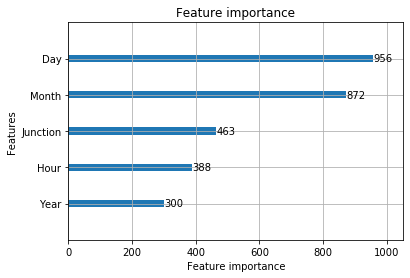

In [13]:
import lightgbm
import matplotlib.pyplot as plt
%matplotlib inline
lightgbm.plot_importance(model)

In [14]:
err = []
y_pred_tot_lgm = []
features = X.columns
feature_importance_df = pd.DataFrame()

from sklearn.model_selection import KFold

fold = KFold(n_splits=15, shuffle=True)
i = 1
for train_index, test_index in fold.split(X, y):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y[train_index], y[test_index]
    m = LGBMRegressor(boosting_type='gbdt',
                       max_depth=5,
                       learning_rate=0.05,
                       n_estimators=5000,
                       min_child_weight=0.01,
                       colsample_bytree=0.5,
                       random_state=1994)
    m.fit(x_train, y_train,
          eval_set=[(x_train,y_train),(x_val, y_val)],
          early_stopping_rounds=200,
          eval_metric='rmse',
          verbose=200)
    pred_y = m.predict(x_val)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = m.feature_importances_
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    print("err_lgm: ",np.sqrt(mean_squared_error(pred_y, y_val)))
    err.append(np.sqrt(mean_squared_error(pred_y, y_val)))
    pred_test = m.predict(X_test)
    i = i + 1
    y_pred_tot_lgm.append(pred_test)

Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 8.86342	training's l2: 78.5602	valid_1's rmse: 8.7645	valid_1's l2: 76.8165
[400]	training's rmse: 8.08688	training's l2: 65.3976	valid_1's rmse: 7.88627	valid_1's l2: 62.1932
[600]	training's rmse: 7.79027	training's l2: 60.6883	valid_1's rmse: 7.5927	valid_1's l2: 57.649
[800]	training's rmse: 7.62575	training's l2: 58.1521	valid_1's rmse: 7.42456	valid_1's l2: 55.1241
[1000]	training's rmse: 7.50947	training's l2: 56.3922	valid_1's rmse: 7.31317	valid_1's l2: 53.4825
[1200]	training's rmse: 7.41402	training's l2: 54.9676	valid_1's rmse: 7.22602	valid_1's l2: 52.2154
[1400]	training's rmse: 7.356	training's l2: 54.1107	valid_1's rmse: 7.17445	valid_1's l2: 51.4727
[1600]	training's rmse: 7.31297	training's l2: 53.4795	valid_1's rmse: 7.13868	valid_1's l2: 50.9608
[1800]	training's rmse: 7.2822	training's l2: 53.0304	valid_1's rmse: 7.11314	valid_1's l2: 50.5968
[2000]	training's rmse: 7.26395	traini

[2000]	training's rmse: 7.2434	training's l2: 52.4669	valid_1's rmse: 7.37569	valid_1's l2: 54.4008
[2200]	training's rmse: 7.22111	training's l2: 52.1444	valid_1's rmse: 7.35793	valid_1's l2: 54.1392
[2400]	training's rmse: 7.2005	training's l2: 51.8472	valid_1's rmse: 7.33946	valid_1's l2: 53.8676
[2600]	training's rmse: 7.18347	training's l2: 51.6022	valid_1's rmse: 7.32567	valid_1's l2: 53.6655
[2800]	training's rmse: 7.16984	training's l2: 51.4066	valid_1's rmse: 7.31445	valid_1's l2: 53.5012
[3000]	training's rmse: 7.16306	training's l2: 51.3094	valid_1's rmse: 7.31198	valid_1's l2: 53.465
[3200]	training's rmse: 7.1549	training's l2: 51.1925	valid_1's rmse: 7.30936	valid_1's l2: 53.4267
[3400]	training's rmse: 7.14509	training's l2: 51.0523	valid_1's rmse: 7.3042	valid_1's l2: 53.3513
[3600]	training's rmse: 7.13989	training's l2: 50.978	valid_1's rmse: 7.30131	valid_1's l2: 53.3091
[3800]	training's rmse: 7.13581	training's l2: 50.9197	valid_1's rmse: 7.29906	valid_1's l2: 53.2

[4000]	training's rmse: 7.13593	training's l2: 50.9216	valid_1's rmse: 7.13189	valid_1's l2: 50.8639
[4200]	training's rmse: 7.13183	training's l2: 50.8631	valid_1's rmse: 7.13048	valid_1's l2: 50.8438
[4400]	training's rmse: 7.12882	training's l2: 50.8201	valid_1's rmse: 7.1295	valid_1's l2: 50.8297
[4600]	training's rmse: 7.12476	training's l2: 50.7621	valid_1's rmse: 7.12886	valid_1's l2: 50.8206
Early stopping, best iteration is:
[4586]	training's rmse: 7.12491	training's l2: 50.7643	valid_1's rmse: 7.12862	valid_1's l2: 50.8173
err_lgm:  7.1286228810582
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 8.88274	training's l2: 78.9031	valid_1's rmse: 8.46186	valid_1's l2: 71.603
[400]	training's rmse: 8.0978	training's l2: 65.5743	valid_1's rmse: 7.69486	valid_1's l2: 59.2108
[600]	training's rmse: 7.80946	training's l2: 60.9877	valid_1's rmse: 7.41993	valid_1's l2: 55.0554
[800]	training's rmse: 7.63616	training's l2: 58.3109	valid_1's rmse: 7.26

[1600]	training's rmse: 7.30536	training's l2: 53.3683	valid_1's rmse: 7.30329	valid_1's l2: 53.3381
[1800]	training's rmse: 7.27886	training's l2: 52.9818	valid_1's rmse: 7.27712	valid_1's l2: 52.9564
[2000]	training's rmse: 7.25097	training's l2: 52.5766	valid_1's rmse: 7.24973	valid_1's l2: 52.5585
[2200]	training's rmse: 7.23145	training's l2: 52.2938	valid_1's rmse: 7.22982	valid_1's l2: 52.2703
[2400]	training's rmse: 7.21024	training's l2: 51.9876	valid_1's rmse: 7.2073	valid_1's l2: 51.9452
[2600]	training's rmse: 7.19756	training's l2: 51.8048	valid_1's rmse: 7.19589	valid_1's l2: 51.7809
[2800]	training's rmse: 7.18069	training's l2: 51.5623	valid_1's rmse: 7.18293	valid_1's l2: 51.5945
[3000]	training's rmse: 7.16882	training's l2: 51.3919	valid_1's rmse: 7.17054	valid_1's l2: 51.4166
[3200]	training's rmse: 7.16086	training's l2: 51.278	valid_1's rmse: 7.16525	valid_1's l2: 51.3408
[3400]	training's rmse: 7.15041	training's l2: 51.1284	valid_1's rmse: 7.15671	valid_1's l2: 

[2600]	training's rmse: 7.16711	training's l2: 51.3675	valid_1's rmse: 7.5494	valid_1's l2: 56.9934
[2800]	training's rmse: 7.15367	training's l2: 51.175	valid_1's rmse: 7.54418	valid_1's l2: 56.9146
[3000]	training's rmse: 7.14454	training's l2: 51.0444	valid_1's rmse: 7.54184	valid_1's l2: 56.8794
[3200]	training's rmse: 7.13228	training's l2: 50.8694	valid_1's rmse: 7.5363	valid_1's l2: 56.7958
[3400]	training's rmse: 7.12353	training's l2: 50.7447	valid_1's rmse: 7.53027	valid_1's l2: 56.7049
[3600]	training's rmse: 7.11538	training's l2: 50.6287	valid_1's rmse: 7.52656	valid_1's l2: 56.6491
[3800]	training's rmse: 7.11063	training's l2: 50.561	valid_1's rmse: 7.5268	valid_1's l2: 56.6528
[4000]	training's rmse: 7.10316	training's l2: 50.4549	valid_1's rmse: 7.52446	valid_1's l2: 56.6176
[4200]	training's rmse: 7.09856	training's l2: 50.3895	valid_1's rmse: 7.52456	valid_1's l2: 56.6191
Early stopping, best iteration is:
[4091]	training's rmse: 7.10035	training's l2: 50.4149	valid_

In [15]:
np.mean(err,0)

7.303825293370237

In [16]:
all_feat = feature_importance_df[["Feature", 
                                      "importance"]].groupby("Feature").mean().sort_values(by="importance", 
                                                                                           ascending=False)
all_feat.reset_index(inplace=True)
important_feat = list(all_feat['Feature'])
all_feat

,Feature,importance
0,Hour,28894.666667
1,Day,26925.866667
2,Month,21379.200000
3,Junction,12520.600000
4,Year,7848.133333
5,Minute,0.000000
6,Second,0.000000


In [17]:
df = X[important_feat]
corr_matrix = df.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

high_cor = [column for column in upper.columns if any(upper[column] > 0.98)]
print(len(high_cor))
print(high_cor)

0
[]


In [18]:
features = [i for i in important_feat if i not in high_cor]
print(len(features))
print(features)

7
['Hour', 'Day', 'Month', 'Junction', 'Year', 'Minute', 'Second']


In [19]:
X1 = X[features]
X_test1 = X_test[features]

In [20]:
err = []
y_pred_tot_lgm = []

from sklearn.model_selection import KFold

fold = KFold(n_splits=15, shuffle=True)
i = 1
for train_index, test_index in fold.split(X1, y):
    x_train, x_val = X1.iloc[train_index], X1.iloc[test_index]
    y_train, y_val = y[train_index], y[test_index]
    m = LGBMRegressor(boosting_type='gbdt',
                       max_depth=5,
                       learning_rate=0.05,
                       n_estimators=5000,
                       min_child_weight=0.01,
                       colsample_bytree=0.5,
                       random_state=1994)
    m.fit(x_train, y_train,
          eval_set=[(x_train,y_train),(x_val, y_val)],
          early_stopping_rounds=200,
          eval_metric='rmse',
          verbose=200)
    pred_y = m.predict(x_val)
    
    print("err_lgm: ",np.sqrt(mean_squared_error(pred_y, y_val)))
    err.append(np.sqrt(mean_squared_error(pred_y, y_val)))
    pred_test = m.predict(X_test1)
    i = i + 1
    y_pred_tot_lgm.append(pred_test)

Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 8.68764	training's l2: 75.4752	valid_1's rmse: 8.74076	valid_1's l2: 76.4008
[400]	training's rmse: 8.09401	training's l2: 65.513	valid_1's rmse: 8.28161	valid_1's l2: 68.5851
[600]	training's rmse: 7.80559	training's l2: 60.9272	valid_1's rmse: 8.07048	valid_1's l2: 65.1326
[800]	training's rmse: 7.60239	training's l2: 57.7963	valid_1's rmse: 7.90285	valid_1's l2: 62.455
[1000]	training's rmse: 7.48413	training's l2: 56.0122	valid_1's rmse: 7.80187	valid_1's l2: 60.8692
[1200]	training's rmse: 7.405	training's l2: 54.834	valid_1's rmse: 7.73203	valid_1's l2: 59.7843
[1400]	training's rmse: 7.33118	training's l2: 53.7461	valid_1's rmse: 7.66769	valid_1's l2: 58.7935
[1600]	training's rmse: 7.30101	training's l2: 53.3047	valid_1's rmse: 7.6493	valid_1's l2: 58.5118
[1800]	training's rmse: 7.26222	training's l2: 52.7398	valid_1's rmse: 7.6221	valid_1's l2: 58.0964
[2000]	training's rmse: 7.22994	trainin

[200]	training's rmse: 8.70557	training's l2: 75.787	valid_1's rmse: 8.61688	valid_1's l2: 74.2505
[400]	training's rmse: 8.12119	training's l2: 65.9538	valid_1's rmse: 8.06151	valid_1's l2: 64.988
[600]	training's rmse: 7.81674	training's l2: 61.1015	valid_1's rmse: 7.76867	valid_1's l2: 60.3522
[800]	training's rmse: 7.61218	training's l2: 57.9453	valid_1's rmse: 7.56388	valid_1's l2: 57.2123
[1000]	training's rmse: 7.49369	training's l2: 56.1553	valid_1's rmse: 7.4505	valid_1's l2: 55.5099
[1200]	training's rmse: 7.42363	training's l2: 55.1103	valid_1's rmse: 7.38741	valid_1's l2: 54.5738
[1400]	training's rmse: 7.36303	training's l2: 54.2143	valid_1's rmse: 7.33181	valid_1's l2: 53.7554
[1600]	training's rmse: 7.32279	training's l2: 53.6232	valid_1's rmse: 7.29784	valid_1's l2: 53.2584
[1800]	training's rmse: 7.28869	training's l2: 53.1251	valid_1's rmse: 7.26522	valid_1's l2: 52.7834
[2000]	training's rmse: 7.25871	training's l2: 52.6888	valid_1's rmse: 7.23456	valid_1's l2: 52.33

[800]	training's rmse: 7.62076	training's l2: 58.076	valid_1's rmse: 7.59236	valid_1's l2: 57.644
[1000]	training's rmse: 7.49611	training's l2: 56.1916	valid_1's rmse: 7.46308	valid_1's l2: 55.6976
[1200]	training's rmse: 7.41169	training's l2: 54.9331	valid_1's rmse: 7.387	valid_1's l2: 54.5677
[1400]	training's rmse: 7.3557	training's l2: 54.1064	valid_1's rmse: 7.32961	valid_1's l2: 53.7232
[1600]	training's rmse: 7.31922	training's l2: 53.5709	valid_1's rmse: 7.2972	valid_1's l2: 53.2492
[1800]	training's rmse: 7.27456	training's l2: 52.9193	valid_1's rmse: 7.25308	valid_1's l2: 52.6071
[2000]	training's rmse: 7.24527	training's l2: 52.494	valid_1's rmse: 7.22719	valid_1's l2: 52.2323
[2200]	training's rmse: 7.22152	training's l2: 52.1504	valid_1's rmse: 7.20598	valid_1's l2: 51.9261
[2400]	training's rmse: 7.20548	training's l2: 51.919	valid_1's rmse: 7.19398	valid_1's l2: 51.7534
[2600]	training's rmse: 7.19417	training's l2: 51.7561	valid_1's rmse: 7.18308	valid_1's l2: 51.5966

[3600]	training's rmse: 7.1537	training's l2: 51.1754	valid_1's rmse: 7.17404	valid_1's l2: 51.4669
[3800]	training's rmse: 7.14888	training's l2: 51.1065	valid_1's rmse: 7.17183	valid_1's l2: 51.4351
[4000]	training's rmse: 7.14183	training's l2: 51.0057	valid_1's rmse: 7.16657	valid_1's l2: 51.3598
[4200]	training's rmse: 7.13664	training's l2: 50.9316	valid_1's rmse: 7.16295	valid_1's l2: 51.3079
[4400]	training's rmse: 7.13263	training's l2: 50.8744	valid_1's rmse: 7.16291	valid_1's l2: 51.3072
[4600]	training's rmse: 7.12833	training's l2: 50.813	valid_1's rmse: 7.15981	valid_1's l2: 51.2629
[4800]	training's rmse: 7.12493	training's l2: 50.7646	valid_1's rmse: 7.15953	valid_1's l2: 51.2589
Early stopping, best iteration is:
[4670]	training's rmse: 7.12676	training's l2: 50.7907	valid_1's rmse: 7.15853	valid_1's l2: 51.2446
err_lgm:  7.158531905555069
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 8.66311	training's l2: 75.0495	valid_1's rmse

[4276]	training's rmse: 7.10565	training's l2: 50.4903	valid_1's rmse: 7.58804	valid_1's l2: 57.5784
err_lgm:  7.588041350530137
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 8.73513	training's l2: 76.3025	valid_1's rmse: 8.17173	valid_1's l2: 66.7771
[400]	training's rmse: 8.1426	training's l2: 66.302	valid_1's rmse: 7.57799	valid_1's l2: 57.4259
[600]	training's rmse: 7.85292	training's l2: 61.6684	valid_1's rmse: 7.28547	valid_1's l2: 53.0781
[800]	training's rmse: 7.6474	training's l2: 58.4827	valid_1's rmse: 7.08609	valid_1's l2: 50.2127
[1000]	training's rmse: 7.53142	training's l2: 56.7222	valid_1's rmse: 6.9797	valid_1's l2: 48.7162
[1200]	training's rmse: 7.44333	training's l2: 55.4031	valid_1's rmse: 6.90912	valid_1's l2: 47.7359
[1400]	training's rmse: 7.36975	training's l2: 54.3132	valid_1's rmse: 6.83911	valid_1's l2: 46.7734
[1600]	training's rmse: 7.33105	training's l2: 53.7442	valid_1's rmse: 6.81133	valid_1's l2: 46.3942
[1800]	t

In [21]:
np.mean(err,0)

7.308991111658943

In [22]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

errxgb = []
y_pred_tot_xgb = []

fold = KFold(n_splits=15, shuffle=True)
i = 1
for train_index, test_index in fold.split(X1, y):
    x_train, x_val = X1.iloc[train_index], X1.iloc[test_index]
    y_train, y_val = y[train_index], y[test_index]
    m = XGBRegressor(boosting_type='gbdt',
                      max_depth=5,
                      learning_rate=0.05,
                      n_estimators=5000,
                      random_state=1994)
    m.fit(x_train, y_train,
          eval_set=[(x_train,y_train),(x_val, y_val)],
          early_stopping_rounds=200,
          eval_metric='rmse',
          verbose=200)
    pred_y = m.predict(x_val)
    
    print("err_xgb: ",np.sqrt(mean_squared_error(pred_y, y_val)))
    errxgb.append(np.sqrt(mean_squared_error(pred_y, y_val)))
    pred_test = m.predict(X_test1)
    i = i + 1
    y_pred_tot_xgb.append(pred_test)

[15:10:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:29.039	validation_1-rmse:29.382
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 200 rounds.


C:\Users\hungu\anaconda.x\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:7.25819	validation_1-rmse:8.09264
[400]	validation_0-rmse:6.71222	validation_1-rmse:7.62289
[600]	validation_0-rmse:6.32998	validation_1-rmse:7.29578
[800]	validation_0-rmse:6.12031	validation_1-rmse:7.12991
[1000]	validation_0-rmse:5.89437	validation_1-rmse:6.93608
[1200]	validation_0-rmse:5.74696	validation_1-rmse:6.81226
[1400]	validation_0-rmse:5.60886	validation_1-rmse:6.69319
[1600]	validation_0-rmse:5.5106	validation_1-rmse:6.6134
[1800]	validation_0-rmse:5.41882	validation_1-rmse:6.53745
[2000]	validation_0-rmse:5.32731	validation_1-rmse:6.45943
[2200]	validation_0-rmse:5.24668	validation_1-rmse:6.40134
[2400]	validation_0-rmse:5.17123	validation_1-rmse:6.33566
[2600]	validation_0-rmse:5.11657	validation_1-rmse:6.2988
[2800]	validation_0-rmse:5.05525	validation_1-rmse:6.24941
[3000]	validation_0-rmse:5.00184	validation_1-rmse:6.20974
[3200]	validation_0-rmse:4.95219	validation_1-rmse:6.17194
[3400]	validation_0-rmse:4.90454	validation_1-rmse:6.13417
[360

C:\Users\hungu\anaconda.x\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:7.3303	validation_1-rmse:7.10664
[400]	validation_0-rmse:6.80529	validation_1-rmse:6.60816
[600]	validation_0-rmse:6.46769	validation_1-rmse:6.32244
[800]	validation_0-rmse:6.22673	validation_1-rmse:6.10597
[1000]	validation_0-rmse:6.01108	validation_1-rmse:5.88919
[1200]	validation_0-rmse:5.8362	validation_1-rmse:5.74665
[1400]	validation_0-rmse:5.69532	validation_1-rmse:5.64357
[1600]	validation_0-rmse:5.57833	validation_1-rmse:5.55509
[1800]	validation_0-rmse:5.49443	validation_1-rmse:5.5007
[2000]	validation_0-rmse:5.40351	validation_1-rmse:5.42743
[2200]	validation_0-rmse:5.33063	validation_1-rmse:5.37581
[2400]	validation_0-rmse:5.24804	validation_1-rmse:5.32072
[2600]	validation_0-rmse:5.17214	validation_1-rmse:5.27178
[2800]	validation_0-rmse:5.10665	validation_1-rmse:5.23065
[3000]	validation_0-rmse:5.04199	validation_1-rmse:5.18674
[3200]	validation_0-rmse:4.9871	validation_1-rmse:5.14733
[3400]	validation_0-rmse:4.9359	validation_1-rmse:5.11804
[3600]

C:\Users\hungu\anaconda.x\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:7.32458	validation_1-rmse:7.1448
[400]	validation_0-rmse:6.74577	validation_1-rmse:6.65855
[600]	validation_0-rmse:6.42368	validation_1-rmse:6.42782
[800]	validation_0-rmse:6.15747	validation_1-rmse:6.19231
[1000]	validation_0-rmse:5.99104	validation_1-rmse:6.06452
[1200]	validation_0-rmse:5.80985	validation_1-rmse:5.90754
[1400]	validation_0-rmse:5.68534	validation_1-rmse:5.82434
[1600]	validation_0-rmse:5.5776	validation_1-rmse:5.74418
[1800]	validation_0-rmse:5.46651	validation_1-rmse:5.659
[2000]	validation_0-rmse:5.3769	validation_1-rmse:5.61104
[2200]	validation_0-rmse:5.29103	validation_1-rmse:5.55817
[2400]	validation_0-rmse:5.21976	validation_1-rmse:5.50593
[2600]	validation_0-rmse:5.15063	validation_1-rmse:5.45533
[2800]	validation_0-rmse:5.08768	validation_1-rmse:5.40664
[3000]	validation_0-rmse:5.03357	validation_1-rmse:5.36858
[3200]	validation_0-rmse:4.98022	validation_1-rmse:5.32552
[3400]	validation_0-rmse:4.93663	validation_1-rmse:5.30019
[3600]

C:\Users\hungu\anaconda.x\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:7.34105	validation_1-rmse:7.4111
[400]	validation_0-rmse:6.79514	validation_1-rmse:6.91828
[600]	validation_0-rmse:6.41789	validation_1-rmse:6.54012
[800]	validation_0-rmse:6.14458	validation_1-rmse:6.28433
[1000]	validation_0-rmse:5.95413	validation_1-rmse:6.12071
[1200]	validation_0-rmse:5.79475	validation_1-rmse:5.98933
[1400]	validation_0-rmse:5.66639	validation_1-rmse:5.88167
[1600]	validation_0-rmse:5.55808	validation_1-rmse:5.80573
[1800]	validation_0-rmse:5.44616	validation_1-rmse:5.72311
[2000]	validation_0-rmse:5.34679	validation_1-rmse:5.65787
[2200]	validation_0-rmse:5.25026	validation_1-rmse:5.59131
[2400]	validation_0-rmse:5.17115	validation_1-rmse:5.52661
[2600]	validation_0-rmse:5.10236	validation_1-rmse:5.48862
[2800]	validation_0-rmse:5.05531	validation_1-rmse:5.45977
[3000]	validation_0-rmse:5.00233	validation_1-rmse:5.43188
[3200]	validation_0-rmse:4.94514	validation_1-rmse:5.3951
[3400]	validation_0-rmse:4.89553	validation_1-rmse:5.36578
[36

C:\Users\hungu\anaconda.x\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:7.25375	validation_1-rmse:8.12436
[400]	validation_0-rmse:6.75311	validation_1-rmse:7.67427
[600]	validation_0-rmse:6.42175	validation_1-rmse:7.37783
[800]	validation_0-rmse:6.14235	validation_1-rmse:7.11755
[1000]	validation_0-rmse:5.9555	validation_1-rmse:6.95616
[1200]	validation_0-rmse:5.79691	validation_1-rmse:6.83193
[1400]	validation_0-rmse:5.66669	validation_1-rmse:6.72613
[1600]	validation_0-rmse:5.54994	validation_1-rmse:6.63631
[1800]	validation_0-rmse:5.44001	validation_1-rmse:6.55619
[2000]	validation_0-rmse:5.35652	validation_1-rmse:6.48477
[2200]	validation_0-rmse:5.2534	validation_1-rmse:6.4108
[2400]	validation_0-rmse:5.17184	validation_1-rmse:6.34914
[2600]	validation_0-rmse:5.10985	validation_1-rmse:6.31344
[2800]	validation_0-rmse:5.03879	validation_1-rmse:6.27358
[3000]	validation_0-rmse:4.97905	validation_1-rmse:6.23349
[3200]	validation_0-rmse:4.93277	validation_1-rmse:6.20978
[3400]	validation_0-rmse:4.88013	validation_1-rmse:6.16822
[360

C:\Users\hungu\anaconda.x\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:7.32303	validation_1-rmse:7.26325
[400]	validation_0-rmse:6.81937	validation_1-rmse:6.81098
[600]	validation_0-rmse:6.40858	validation_1-rmse:6.43822
[800]	validation_0-rmse:6.13957	validation_1-rmse:6.19776
[1000]	validation_0-rmse:5.97247	validation_1-rmse:6.0593
[1200]	validation_0-rmse:5.83407	validation_1-rmse:5.95035
[1400]	validation_0-rmse:5.67262	validation_1-rmse:5.82536
[1600]	validation_0-rmse:5.55507	validation_1-rmse:5.73168
[1800]	validation_0-rmse:5.48177	validation_1-rmse:5.66924
[2000]	validation_0-rmse:5.39274	validation_1-rmse:5.59931
[2200]	validation_0-rmse:5.3075	validation_1-rmse:5.53625
[2400]	validation_0-rmse:5.23835	validation_1-rmse:5.48643
[2600]	validation_0-rmse:5.16994	validation_1-rmse:5.42346
[2800]	validation_0-rmse:5.1135	validation_1-rmse:5.38177
[3000]	validation_0-rmse:5.03987	validation_1-rmse:5.32558
[3200]	validation_0-rmse:4.9781	validation_1-rmse:5.27707
[3400]	validation_0-rmse:4.92949	validation_1-rmse:5.23718
[3600

C:\Users\hungu\anaconda.x\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:7.32353	validation_1-rmse:7.56982
[400]	validation_0-rmse:6.84894	validation_1-rmse:7.11069
[600]	validation_0-rmse:6.44085	validation_1-rmse:6.71739
[800]	validation_0-rmse:6.16841	validation_1-rmse:6.45619
[1000]	validation_0-rmse:5.96672	validation_1-rmse:6.27175
[1200]	validation_0-rmse:5.81496	validation_1-rmse:6.15076
[1400]	validation_0-rmse:5.67413	validation_1-rmse:6.04231
[1600]	validation_0-rmse:5.56822	validation_1-rmse:5.95828
[1800]	validation_0-rmse:5.46009	validation_1-rmse:5.865
[2000]	validation_0-rmse:5.36644	validation_1-rmse:5.79009
[2200]	validation_0-rmse:5.27577	validation_1-rmse:5.71247
[2400]	validation_0-rmse:5.20522	validation_1-rmse:5.66702
[2600]	validation_0-rmse:5.1384	validation_1-rmse:5.61551
[2800]	validation_0-rmse:5.07584	validation_1-rmse:5.56805
[3000]	validation_0-rmse:5.01098	validation_1-rmse:5.52029
[3200]	validation_0-rmse:4.95444	validation_1-rmse:5.47714
[3400]	validation_0-rmse:4.91359	validation_1-rmse:5.45056
[360

C:\Users\hungu\anaconda.x\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:7.28662	validation_1-rmse:7.63233
[400]	validation_0-rmse:6.72496	validation_1-rmse:7.17863
[600]	validation_0-rmse:6.36073	validation_1-rmse:6.89017
[800]	validation_0-rmse:6.09764	validation_1-rmse:6.69332
[1000]	validation_0-rmse:5.90146	validation_1-rmse:6.53611
[1200]	validation_0-rmse:5.78359	validation_1-rmse:6.45004
[1400]	validation_0-rmse:5.64722	validation_1-rmse:6.33803
[1600]	validation_0-rmse:5.54248	validation_1-rmse:6.25328
[1800]	validation_0-rmse:5.43733	validation_1-rmse:6.17697
[2000]	validation_0-rmse:5.3443	validation_1-rmse:6.10955
[2200]	validation_0-rmse:5.25855	validation_1-rmse:6.04278
[2400]	validation_0-rmse:5.18455	validation_1-rmse:5.97876
[2600]	validation_0-rmse:5.12618	validation_1-rmse:5.92856
[2800]	validation_0-rmse:5.05749	validation_1-rmse:5.88158
[3000]	validation_0-rmse:4.99679	validation_1-rmse:5.83721
[3200]	validation_0-rmse:4.94808	validation_1-rmse:5.807
[3400]	validation_0-rmse:4.89385	validation_1-rmse:5.77305
[360

C:\Users\hungu\anaconda.x\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:7.3339	validation_1-rmse:7.44446
[400]	validation_0-rmse:6.81623	validation_1-rmse:6.98572
[600]	validation_0-rmse:6.41725	validation_1-rmse:6.64354
[800]	validation_0-rmse:6.13927	validation_1-rmse:6.4252
[1000]	validation_0-rmse:5.93008	validation_1-rmse:6.24475
[1200]	validation_0-rmse:5.79401	validation_1-rmse:6.11974
[1400]	validation_0-rmse:5.66993	validation_1-rmse:6.03169
[1600]	validation_0-rmse:5.55534	validation_1-rmse:5.93649
[1800]	validation_0-rmse:5.45385	validation_1-rmse:5.84921
[2000]	validation_0-rmse:5.3679	validation_1-rmse:5.78521
[2200]	validation_0-rmse:5.29376	validation_1-rmse:5.73051
[2400]	validation_0-rmse:5.22143	validation_1-rmse:5.68249
[2600]	validation_0-rmse:5.15594	validation_1-rmse:5.636
[2800]	validation_0-rmse:5.10163	validation_1-rmse:5.59585
[3000]	validation_0-rmse:5.04131	validation_1-rmse:5.54763
[3200]	validation_0-rmse:4.98408	validation_1-rmse:5.50228
[3400]	validation_0-rmse:4.93319	validation_1-rmse:5.46498
[3600]

C:\Users\hungu\anaconda.x\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:7.29527	validation_1-rmse:7.43827
[400]	validation_0-rmse:6.77437	validation_1-rmse:7.01248
[600]	validation_0-rmse:6.36572	validation_1-rmse:6.65632
[800]	validation_0-rmse:6.12041	validation_1-rmse:6.45107
[1000]	validation_0-rmse:5.94398	validation_1-rmse:6.30772
[1200]	validation_0-rmse:5.76434	validation_1-rmse:6.13804
[1400]	validation_0-rmse:5.62843	validation_1-rmse:6.02208
[1600]	validation_0-rmse:5.52255	validation_1-rmse:5.94934
[1800]	validation_0-rmse:5.43028	validation_1-rmse:5.89227
[2000]	validation_0-rmse:5.35575	validation_1-rmse:5.84621
[2200]	validation_0-rmse:5.2687	validation_1-rmse:5.77419
[2400]	validation_0-rmse:5.18445	validation_1-rmse:5.71479
[2600]	validation_0-rmse:5.11811	validation_1-rmse:5.67417
[2800]	validation_0-rmse:5.0555	validation_1-rmse:5.63115
[3000]	validation_0-rmse:5.01052	validation_1-rmse:5.6091
[3200]	validation_0-rmse:4.96261	validation_1-rmse:5.58264
[3400]	validation_0-rmse:4.91726	validation_1-rmse:5.55412
[360

C:\Users\hungu\anaconda.x\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:7.35533	validation_1-rmse:6.97147
[400]	validation_0-rmse:6.83843	validation_1-rmse:6.50138
[600]	validation_0-rmse:6.46881	validation_1-rmse:6.15688
[800]	validation_0-rmse:6.19975	validation_1-rmse:5.91488
[1000]	validation_0-rmse:6.02061	validation_1-rmse:5.77046
[1200]	validation_0-rmse:5.85927	validation_1-rmse:5.63249
[1400]	validation_0-rmse:5.72606	validation_1-rmse:5.52093
[1600]	validation_0-rmse:5.60716	validation_1-rmse:5.43813
[1800]	validation_0-rmse:5.5035	validation_1-rmse:5.36592
[2000]	validation_0-rmse:5.4049	validation_1-rmse:5.27687
[2200]	validation_0-rmse:5.3184	validation_1-rmse:5.2059
[2400]	validation_0-rmse:5.25756	validation_1-rmse:5.17139
[2600]	validation_0-rmse:5.19772	validation_1-rmse:5.13747
[2800]	validation_0-rmse:5.12519	validation_1-rmse:5.08617
[3000]	validation_0-rmse:5.07589	validation_1-rmse:5.05168
[3200]	validation_0-rmse:5.03221	validation_1-rmse:5.01972
[3400]	validation_0-rmse:4.98154	validation_1-rmse:4.99004
[3600

C:\Users\hungu\anaconda.x\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:7.35533	validation_1-rmse:7.00491
[400]	validation_0-rmse:6.81777	validation_1-rmse:6.52886
[600]	validation_0-rmse:6.41803	validation_1-rmse:6.18047
[800]	validation_0-rmse:6.15147	validation_1-rmse:5.93744
[1000]	validation_0-rmse:6.00321	validation_1-rmse:5.81493
[1200]	validation_0-rmse:5.85208	validation_1-rmse:5.70541
[1400]	validation_0-rmse:5.68984	validation_1-rmse:5.58709
[1600]	validation_0-rmse:5.57085	validation_1-rmse:5.49687
[1800]	validation_0-rmse:5.46919	validation_1-rmse:5.41843
[2000]	validation_0-rmse:5.39427	validation_1-rmse:5.37412
[2200]	validation_0-rmse:5.31782	validation_1-rmse:5.31994
[2400]	validation_0-rmse:5.2412	validation_1-rmse:5.27222
[2600]	validation_0-rmse:5.17951	validation_1-rmse:5.22703
[2800]	validation_0-rmse:5.10669	validation_1-rmse:5.19078
[3000]	validation_0-rmse:5.04714	validation_1-rmse:5.14573
[3200]	validation_0-rmse:5.00435	validation_1-rmse:5.12013
[3400]	validation_0-rmse:4.95621	validation_1-rmse:5.09325
[3

C:\Users\hungu\anaconda.x\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:7.30446	validation_1-rmse:7.39383
[400]	validation_0-rmse:6.81181	validation_1-rmse:6.97726
[600]	validation_0-rmse:6.37316	validation_1-rmse:6.56506
[800]	validation_0-rmse:6.1312	validation_1-rmse:6.35118
[1000]	validation_0-rmse:5.94869	validation_1-rmse:6.18175
[1200]	validation_0-rmse:5.80378	validation_1-rmse:6.05957
[1400]	validation_0-rmse:5.6712	validation_1-rmse:5.93661
[1600]	validation_0-rmse:5.54298	validation_1-rmse:5.82463
[1800]	validation_0-rmse:5.44492	validation_1-rmse:5.7531
[2000]	validation_0-rmse:5.36316	validation_1-rmse:5.67062
[2200]	validation_0-rmse:5.28526	validation_1-rmse:5.61775
[2400]	validation_0-rmse:5.20963	validation_1-rmse:5.56489
[2600]	validation_0-rmse:5.14821	validation_1-rmse:5.52841
[2800]	validation_0-rmse:5.08646	validation_1-rmse:5.48179
[3000]	validation_0-rmse:5.03051	validation_1-rmse:5.43773
[3200]	validation_0-rmse:4.96889	validation_1-rmse:5.38953
[3400]	validation_0-rmse:4.93065	validation_1-rmse:5.36707
[360

C:\Users\hungu\anaconda.x\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:7.34491	validation_1-rmse:7.04803
[400]	validation_0-rmse:6.88551	validation_1-rmse:6.66762
[600]	validation_0-rmse:6.46671	validation_1-rmse:6.28086
[800]	validation_0-rmse:6.21368	validation_1-rmse:6.06417
[1000]	validation_0-rmse:6.0119	validation_1-rmse:5.86451
[1200]	validation_0-rmse:5.85762	validation_1-rmse:5.73635
[1400]	validation_0-rmse:5.72305	validation_1-rmse:5.6149
[1600]	validation_0-rmse:5.60245	validation_1-rmse:5.53024
[1800]	validation_0-rmse:5.47438	validation_1-rmse:5.42239
[2000]	validation_0-rmse:5.3826	validation_1-rmse:5.33778
[2200]	validation_0-rmse:5.3074	validation_1-rmse:5.27597
[2400]	validation_0-rmse:5.23614	validation_1-rmse:5.21577
[2600]	validation_0-rmse:5.16482	validation_1-rmse:5.15164
[2800]	validation_0-rmse:5.10893	validation_1-rmse:5.11263
[3000]	validation_0-rmse:5.05193	validation_1-rmse:5.06858
[3200]	validation_0-rmse:4.99762	validation_1-rmse:5.03341
[3400]	validation_0-rmse:4.94835	validation_1-rmse:4.9985
[3600]

C:\Users\hungu\anaconda.x\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:7.29633	validation_1-rmse:7.42255
[400]	validation_0-rmse:6.79241	validation_1-rmse:6.98042
[600]	validation_0-rmse:6.43965	validation_1-rmse:6.66868
[800]	validation_0-rmse:6.17725	validation_1-rmse:6.41645
[1000]	validation_0-rmse:5.98222	validation_1-rmse:6.25366
[1200]	validation_0-rmse:5.83459	validation_1-rmse:6.12243
[1400]	validation_0-rmse:5.70109	validation_1-rmse:6.00447
[1600]	validation_0-rmse:5.56867	validation_1-rmse:5.87891
[1800]	validation_0-rmse:5.47596	validation_1-rmse:5.78005
[2000]	validation_0-rmse:5.39576	validation_1-rmse:5.70603
[2200]	validation_0-rmse:5.3198	validation_1-rmse:5.64279
[2400]	validation_0-rmse:5.24536	validation_1-rmse:5.5842
[2600]	validation_0-rmse:5.17617	validation_1-rmse:5.51796
[2800]	validation_0-rmse:5.11029	validation_1-rmse:5.45312
[3000]	validation_0-rmse:5.05461	validation_1-rmse:5.41198
[3200]	validation_0-rmse:4.99202	validation_1-rmse:5.36097
[3400]	validation_0-rmse:4.9444	validation_1-rmse:5.32442
[360

In [23]:
np.mean(errxgb,0)

5.220201791967216

In [24]:
(np.mean(errxgb, 0) + np.mean(err, 0))/2

6.2645964518130794

In [25]:
submission = pd.DataFrame()
submission['ID'] = test['ID']
submission['Vehicles'] = (np.mean(y_pred_tot_xgb, 0)+np.mean(y_pred_tot_lgm, 0))/2.astype('int')
submission.to_csv('LGB.csv', index=False)

In [26]:
submission.head()

,ID,Vehicles
0,20170701001,79
1,20170701011,69
2,20170701021,60
3,20170701031,52
4,20170701041,45
